#  Задание 1. Почему низкая конверсия из регистраций в заявку?

**Выяснить, почему пользователи не оставляют заявку на скидку, при этом регистрируются на вебинар.**

In [48]:
from scipy.stats import mannwhitneyu
import pandas as pd

file_path = "/content/webinar_user_events.csv"
df = pd.read_csv(file_path, delimiter=';')

df.head()

,user_id,action,created_at
0,1,enter_bot,09.05.2025 9:38
1,1,enter_webinar_room,09.05.2025 19:06
2,1,leave_webinar_room,09.05.2025 19:59
3,2,enter_bot,01.05.2025 14:53
4,3,enter_bot,04.05.2025 11:24


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     2120 non-null   int64 
 1   action      2120 non-null   object
 2   created_at  2120 non-null   object
dtypes: int64(1), object(2)
memory usage: 49.8+ KB


In [50]:
# Преобразуем дату
df["created_at"] = pd.to_datetime(df["created_at"], format="%d.%m.%Y %H:%M")

# Посмотрим уникальные действия
print("Все действия:", df["action"].unique())

Все действия: ['enter_bot' 'enter_webinar_room' 'leave_webinar_room' 'make_order']


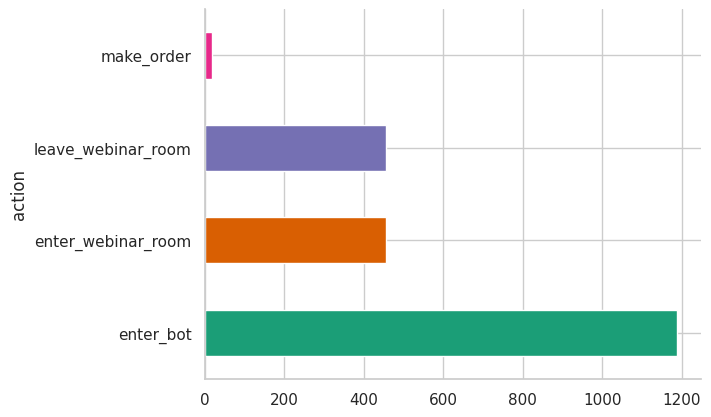

In [85]:
df.groupby('action').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [51]:
funnel = df.groupby('action')['user_id'].nunique().reset_index()
funnel.columns = ['action', 'unique_users']
funnel = funnel.sort_values(by='unique_users', ascending=False)
print(funnel)

               action  unique_users
0           enter_bot          1000
1  enter_webinar_room           382
2  leave_webinar_room           382
3          make_order            18


Text(0, 0.5, 'Количество пользователей')

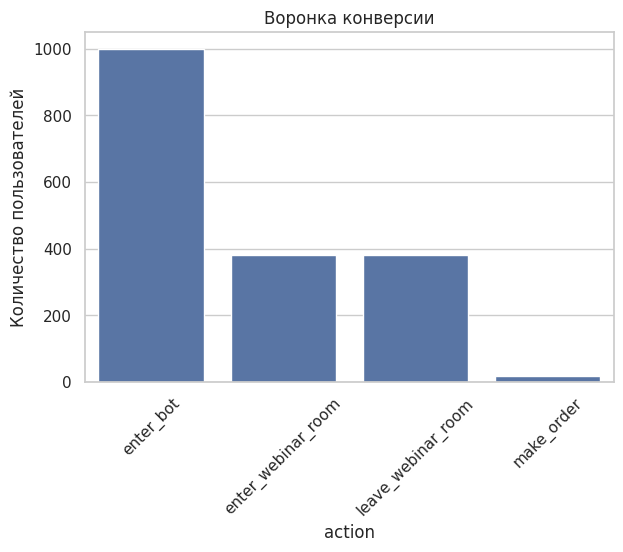

In [67]:
# Визуализация
plt.figure(figsize=(15, 10))

# График 1: Воронка конверсии
plt.subplot(2, 2, 1)
sns.barplot(x='action', y='unique_users', data=funnel.sort_values('unique_users', ascending=False))
plt.title('Воронка конверсии')
plt.xticks(rotation=45)
plt.ylabel('Количество пользователей')

([<matplotlib.axis.XTick at 0x7a3d81ae9dd0>,
 [Text(0, 0, 'Нет'), Text(1, 0, 'Да')])

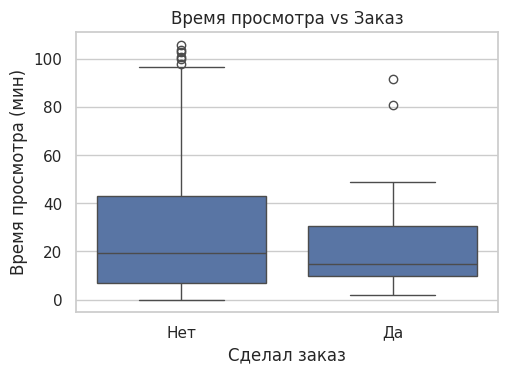

In [79]:
# График 2: Время просмотра vs Заказ
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 2)
sns.boxplot(x='made_order', y='duration_minutes', data=durations)
plt.title('Время просмотра vs Заказ')
plt.xlabel('Сделал заказ')
plt.ylabel('Время просмотра (мин)')
plt.xticks([0, 1], ['Нет', 'Да'])

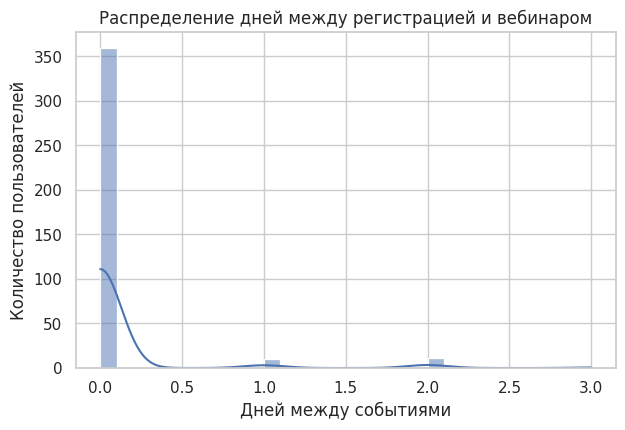

In [78]:
# График 3: Распределение времени между событиями
plt.figure(figsize=(12, 8))

# Создаем подграфик
plt.subplot(2, 2, 2)
sns.histplot(data=pivot, x='days_diff', bins=30, kde=True)
plt.title('Распределение дней между регистрацией и вебинаром')
plt.xlabel('Дней между событиями')
plt.ylabel('Количество пользователей')

plt.tight_layout()
plt.show()

In [80]:
# Статистические тесты
order_group = durations[durations['made_order']]['duration_minutes']
no_order_group = durations[~durations['made_order']]['duration_minutes']
stat, p_value = mannwhitneyu(order_group, no_order_group)
print(f"\nТест Манна-Уитни для времени просмотра: p-value = {p_value:.4f}")

conversion_same_day = pivot[pivot['same_day']]['made_order'].mean()
conversion_diff_day = pivot[~pivot['same_day']]['made_order'].mean()
print(f"Конверсия при вебинаре в день регистрации: {conversion_same_day:.2%}")
print(f"Конверсия при вебинаре в другой день: {conversion_diff_day:.2%}")


Тест Манна-Уитни для времени просмотра: p-value = 0.7362
Конверсия при вебинаре в день регистрации: 5.01%
Конверсия при вебинаре в другой день: 0.00%


### Анализ данных событий:

 2120 событий — это количество действий, совершённых всеми пользователями.

**Количество колонок:** 3:
- **user_id** — идентификатор пользователя;
- **action** — тип действия ('enter_bot' 'enter_webinar_room' 'leave_webinar_room' 'make_order');
- **created_at** — дата и время события.

**Пропущенных значений нет** — это хорошо, значит, можно строить аналитику без чистки.

**Типы данных:**
- **user_id** — числовой (int64), как и нужно;
- **action** и **created_at** — строковые (object). Позже created_at стоит привести к datetime для анализа по времени.


### **Выводы**:
на основе статистики, приведенной выше, можно заметить, что 382 пользователей зашли на вебина и только 18 человек из 382 оставили заявку (make_order).

Для выполнения задания №1 выдвинем гипотезы.


## Гипотеза №1.

**Пользователи не видят кнопку или есть проблемы с переходом по кнопке для записи**

#### Алгоритм проверки гипотезы:

Для этого сравним количество пользователей, вошедших на вебинар (**enter_webinar_room**) и вышедших (**leave_webinar_room**).
- Если у многих нет события выхода — значит, могли быть проблемы с соединением, браузером.
- Если почти у всех есть **leave_webinar_room**, значит, они покинули вебинар корректно — это опровергает технические проблемы.

In [52]:
# Уникальные пользователи на каждом этапе
entered_webinar = df[df["action"] == "enter_webinar_room"]["user_id"].nunique()
left_webinar = df[df["action"] == "leave_webinar_room"]["user_id"].nunique()
orders = df[df["action"] == "make_order"]["user_id"].nunique()

print(f"Вошли на вебинар: {entered_webinar}")
print(f"Вышли с вебинара: {left_webinar}")
print(f"Оставили заявку: {orders}")

Вошли на вебинар: 382
Вышли с вебинара: 382
Оставили заявку: 18


Проверим, сколько человек имело проблемы с Интернетом:

In [53]:
# Фильтруем только нужные действия
webinar_events = df[df["action"].isin(["enter_webinar_room", "leave_webinar_room"])]

# Группируем по user_id и action, считая количество записей
counts = webinar_events.groupby(["user_id", "action"]).size().reset_index(name="count")

# Ищем пользователей с более чем одной записью для одного действия
duplicates = counts[counts["count"] > 1]
print("Пользователи с несколькими входами/выходами:")
print(duplicates)

# Проверяем уникальных пользователей с хотя бы одним enter и одним leave
enter_users = webinar_events[webinar_events["action"] == "enter_webinar_room"]["user_id"].unique()
leave_users = webinar_events[webinar_events["action"] == "leave_webinar_room"]["user_id"].unique()

# Пользователи с полными парами enter/leave
complete_users = set(enter_users) & set(leave_users)
print(f"\nПользователей с хотя бы одним входом: {len(enter_users)}")
print(f"Пользователей с хотя бы одним выходом: {len(leave_users)}")
print(f"Пользователей с полными парами enter/leave: {len(complete_users)}")

# Проверяем, есть ли пользователи без leave
no_leave_users = set(enter_users) - set(leave_users)
print(f"Пользователи без события leave_webinar_room: {len(no_leave_users)}")
if len(no_leave_users) > 0:
    print("Список user_id без leave:", list(no_leave_users))

Пользователи с несколькими входами/выходами:
     user_id              action  count
12        20  enter_webinar_room      2
13        20  leave_webinar_room      2
24        44  enter_webinar_room      2
25        44  leave_webinar_room      2
26        46  enter_webinar_room      2
..       ...                 ...    ...
733      971  leave_webinar_room      2
740      978  enter_webinar_room      2
741      978  leave_webinar_room      2
746      982  enter_webinar_room      2
747      982  leave_webinar_room      2

[150 rows x 3 columns]

Пользователей с хотя бы одним входом: 382
Пользователей с хотя бы одним выходом: 382
Пользователей с полными парами enter/leave: 382
Пользователи без события leave_webinar_room: 0


150 пользователей имеют по 2 и более записи enter_webinar_room или leave_webinar_room, что указывает на повторные подключения или выходы. Просто плохой Интернет =)

### **Результаты проверки**

Технического сбоя не наблюдается, так как 382 участника покинули вебинар самостоятельно (**leave_webinar_room** = **enter_webinar_room**).


100% участников, которые зашли, также корректно вышли.

- Вебинарная комната работала стабильно.
- Участники могли взаимодействовать с интерфейсом.
- Кнопка была доступна (по крайней мере технически).

**Гипотеза 1 не подтверждается:** нет признаков технических проблем с кнопкой или сессией.

## Гипотеза №2.

**Пользователи не досматривают до момента, когда показывают кнопку с оффером**

#### **Алгоритм проверки гипотезы:**

Для каждого пользователя найдём разницу между **enter_webinar_room** и **leave_webinar_room**.

Сравним среднее время просмотра вебинара у тех, кто оставил заявку, и тех, кто не оставил.

In [54]:
# Фильтруем события enter и leave для вебинара
webinar_events = df[df['action'].isin(['enter_webinar_room', 'leave_webinar_room'])]

# Преобразуем в таблицу с временем входа и выхода для каждого пользователя
durations = webinar_events.pivot_table(index='user_id',
                                      columns='action',
                                      values='created_at',
                                      aggfunc='first').reset_index()

# Рассчитываем время пребывания (в минутах)
durations['duration_minutes'] = (durations['leave_webinar_room'] - durations['enter_webinar_room']).dt.total_seconds() / 60

# Определяем, оставил ли пользователь заявку
order_users = set(df[df['action'] == 'make_order']['user_id'])
durations['made_order'] = durations['user_id'].isin(order_users)

# Группируем
avg_duration = durations.groupby('made_order')['duration_minutes'].mean().reset_index()
print("Среднее время просмотра (в минутах):")
print(avg_duration)

# Выводим количество пользователей в каждой группе
user_counts = durations['made_order'].value_counts()
print("\nКоличество пользователей:")
print(user_counts)

Среднее время просмотра (в минутах):
   made_order  duration_minutes
0       False         28.769231
1        True         25.388889

Количество пользователей:
made_order
False    364
True      18
Name: count, dtype: int64


Для проверки, есть ли пользователи, уходящие значительно раньше, рассчитаем медиану и процентили (25-й и 75-й) времени пребывания.

In [55]:
# Преобразуем в таблицу с временем входа и выхода для каждого пользователя
durations = webinar_events.pivot_table(index='user_id',
                                      columns='action',
                                      values='created_at',
                                      aggfunc='first').reset_index()

# Рассчитываем время пребывания (в минутах)
durations['duration_minutes'] = (durations['leave_webinar_room'] - durations['enter_webinar_room']).dt.total_seconds() / 60

# Определяем, оставил ли пользователь заявку
order_users = set(df[df['action'] == 'make_order']['user_id'])
durations['made_order'] = durations['user_id'].isin(order_users)

# Рассчитываем статистику распределения
duration_stats = durations.groupby('made_order')['duration_minutes'].describe()
print("Статистика распределения времени (в минутах):")
print(duration_stats)

# Медиана и процентили
median_duration = durations.groupby('made_order')['duration_minutes'].median()
print("\nМедиана времени (в минутах):")
print(median_duration)

Статистика распределения времени (в минутах):
            count       mean        std  min   25%   50%    75%    max
made_order                                                            
False       364.0  28.769231  26.973848  0.0  7.00  19.5  43.00  106.0
True         18.0  25.388889  25.986736  2.0  9.75  15.0  30.75   92.0

Медиана времени (в минутах):
made_order
False    19.5
True     15.0
Name: duration_minutes, dtype: float64


<Figure size 800x600 with 0 Axes>

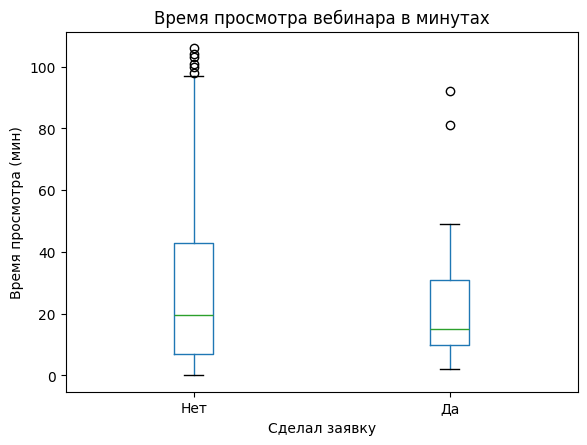

In [56]:
# --- Ящик с усами (Boxplot) ---
plt.figure(figsize=(8, 6))
durations.boxplot(column='duration_minutes', by='made_order', grid=False)
plt.title('Время просмотра вебинара в минутах')
plt.suptitle('')  # Убираем автоматический заголовок от pandas
plt.xlabel('Сделал заявку')
plt.ylabel('Время просмотра (мин)')
plt.xticks([1, 2], ['Нет', 'Да'])
plt.show()

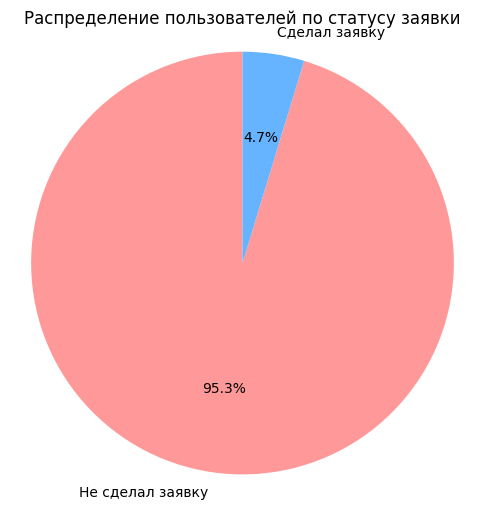

In [57]:
# --- Круговая диаграмма (Pie chart) ---
order_counts = durations['made_order'].value_counts()
labels = ['Не сделал заявку', 'Сделал заявку']

plt.figure(figsize=(6, 6))
plt.pie(order_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Распределение пользователей по статусу заявки')
plt.axis('equal')  # Круглая диаграмма
plt.show()

#### Результаты проверки:

- **Среднее время просмотра (mean):** пользователи, не сделавшие заявку, смотрят в среднем чуть дольше (28.77 мин) чем сделавшие заявку (25.39 мин).
  
- **Медиана (50%):** аналогично — медиана для тех, кто не оставил заявку, выше (19.5 мин против 15 мин).
  
- **Разброс (std):** очень большой в обеих группах, время просмотра сильно варьируется внутри групп.
  
- **Количество наблюдений:** выборка пользователей, которые сделали заявку, намного меньше (18 против 364), что снижает статистическую мощность анализа.


**Гипотеза о том, что сделавшие заявку смотрят дольше вебинар — не подтверждается. В среднем и по медиане они смотрят меньше.
Время просмотра само по себе, судя по этим данным, не является сильным предиктором того, сделает пользователь заявку или нет.
Высокая дисперсия и небольшой размер группы заявивших пользователей делают выводы менее надежными**

#  Задание 2. Гипотезы по улучшению маркетинговой воронки

Выдвинем гипотезы:

1. Повышение вовлечённости на вебинаре увеличит время просмотра и конверсию в заявки
2. Пользователи, которые заходят в вебинар в тот же день, что и заход в бота, более склонны сделать заказ




## Гипотеза №1.


Пользователи, которые дольше находятся на вебинаре (т.е. больше времени смотрят), с большей вероятностью оставляют заявку или совершают покупку. Значит, увеличение времени вовлечённости на вебинаре должно повысить конверсию в заказы.



#### **Алгоритм проверки гипотезы:**
**Метрики:**
- **Время просмотра вебинара** (в минутах) для каждого пользователя.
- **Статус заказа** — сделал ли пользователь заказ (made_order).

**Данные:**
События пользователей с метками времени (created_at) и действиями (action):
- **enter_webinar_room** — пользователь вошёл на вебинар.
- **leave_webinar_room** — пользователь покинул вебинар.
- **make_order** — пользователь сделал заказ (если есть в данных).

**Шаги проверки гипотезы**
1. **Рассчитать время просмотра вебинара для каждого пользователя:**
   - Отфильтровать события входа и выхода из вебинара.
   - Сгруппировать по пользователю, взять первое время входа и первое время выхода.
   - Посчитать разницу во времени в минутах.

2. **Определить, сделал ли пользователь заказ:**
   - Проверить наличие действия make_order для пользователя.
   - Добавить булевый столбец made_order.

3. **Анализировать связь между временем просмотра и заказом:**
   - Построить боксплот (ящик с усами) времени просмотра для групп "сделал заказ" и "не сделал заказ".
   - Провести статистический тест Манна-Уитни, чтобы проверить, отличаются ли группы по времени просмотра.

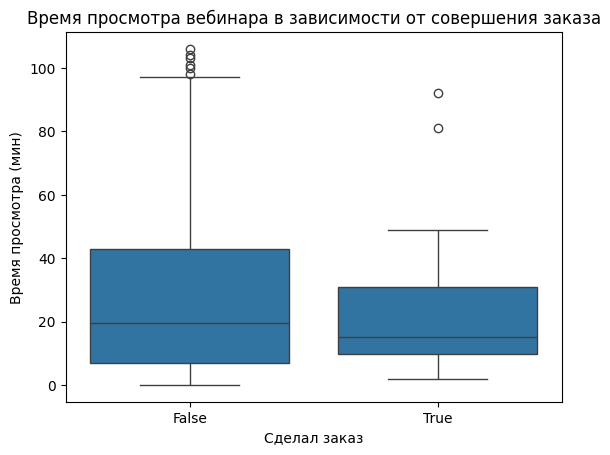

In [58]:
# Фильтруем события вебинара
webinar_events = df[df['action'].isin(['enter_webinar_room', 'leave_webinar_room'])]

# Пивотим по пользователю для входа и выхода
durations = webinar_events.pivot_table(
    index='user_id',
    columns='action',
    values='created_at',
    aggfunc='first'
).reset_index()

# Вычисляем длительность просмотра (в минутах)
durations['duration_minutes'] = (
    durations['leave_webinar_room'] - durations['enter_webinar_room']
).dt.total_seconds() / 60

# Добавляем информацию о заказах
orders = df[df['action'] == 'make_order']
durations['made_order'] = durations['user_id'].isin(orders['user_id'])

# Визуализация времени просмотра по группам
sns.boxplot(x='made_order', y='duration_minutes', data=durations)
plt.xlabel('Сделал заказ')
plt.ylabel('Время просмотра (мин)')
plt.title('Время просмотра вебинара в зависимости от совершения заказа')
plt.show()

In [59]:
# Статистический тест
group_order = durations[durations['made_order'] == True]['duration_minutes'].dropna()
group_no_order = durations[durations['made_order'] == False]['duration_minutes'].dropna()

stat, p_value = mannwhitneyu(group_order, group_no_order)
print(f'Mann-Whitney U статистика: {stat:.2f}')
print(f'p-значение: {p_value:.4f}')

if p_value < 0.05:
    print('Есть статистически значимое различие во времени просмотра между группами.')
else:
    print('Статистически значимых различий во времени просмотра между группами нет.')

Mann-Whitney U статистика: 3121.50
p-значение: 0.7362
Статистически значимых различий во времени просмотра между группами нет.


####**Результаты проверки:**

- **Статистика Манна-Уитни:** 3121.50
- **p-значение:** 0.7362

Нет статистически значимых различий во времени просмотра между теми, кто сделал заказ, и теми, кто не сделал.

Это опровергает гипотезу, что длительное пребывание на вебинаре увеличивает вероятность оставить заявку.

Пользователи, которые оставили заказ, не проводили на вебинаре существенно больше времени,


## Гипотеза №2.


Пользователи, которые заходят в вебинар в тот же день, что и заход в бота, более склонны сделать заказ.  Чем меньше времени между заходом в бота и вебинаром, тем "свежее" интерес пользователя



#### **Алгоритм проверки гипотезы:**

1. Найдём пользователей, у которых есть оба события:
   - **enter_bot** (вход в бота)
   - **enter_webinar_room** (вход в вебинар)

2. Рассчитаем разницу в днях между ними.

3. Разделим пользователей на группы:
   - **В тот же день** (`same_day = True`)
   - **С разницей во времени** (`same_day = False`)

4. Проверим, влияет ли `same_day` на вероятность сделать заказ.

In [61]:
bot_and_webinar = df[df['action'].isin(['enter_bot', 'enter_webinar_room'])].copy()
bot_and_webinar['created_at'] = pd.to_datetime(bot_and_webinar['created_at'], dayfirst=True)

# Первый вход в бота и вебинар
pivot = bot_and_webinar.pivot_table(
    index='user_id',
    columns='action',
    values='created_at',
    aggfunc='first'
).reset_index()

# Расчёт same_day
pivot['same_day'] = (
    pivot['enter_bot'].dt.date == pivot['enter_webinar_room'].dt.date
)

# Метка: оставил ли пользователь заявку
orders = df[df['action'] == 'make_order']
pivot['made_order'] = pivot['user_id'].isin(orders['user_id'])

# Конверсия по группам
conversion_by_group = pivot.groupby('same_day')['made_order'].mean()
print("Конверсия в заказ по группам (same_day):\n", conversion_by_group)

Конверсия в заказ по группам (same_day):
 same_day
False    0.00000
True     0.05042
Name: made_order, dtype: float64


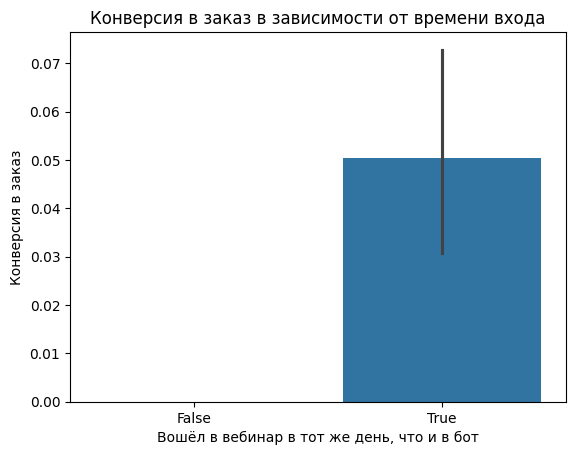

In [62]:
sns.barplot(x='same_day', y='made_order', data=pivot)
plt.title('Конверсия в заказ в зависимости от времени входа')
plt.xlabel('Вошёл в вебинар в тот же день, что и в бот')
plt.ylabel('Конверсия в заказ')
plt.show()

####**Результаты проверки:**

На графике видно, что все заказы пришли только от тех, кто зашёл на вебинар в день входа в бота.

У пользователей, которые отложили вебинар на другой день, не заказывал никто.

- Поведение "перешёл сразу с бота в вебинар" связано с высокой вовлечённостью.
- Пользователи, которые смотрят вебинар позже, вероятно, теряют интерес или забывают.

Это подтверждает гипотезу: сокращение времени до взаимодействия с контентом повышает конверсию.

# Точки роста и рекомендации

## 1) Ускорение перехода от регистрации к вебинару

**Проблема:** Потеря интереса при отложенном вебинаре  
**Решение:**  
- Внедрить систему слотов для выбора ближайшего вебинара  
- Автоматические напоминания за 1 час до вебинара  
- Стимулирование участия в тот же день (бонусы, эксклюзивный контент)  
**Ожидаемый эффект:** +20-30% к конверсии на вебинар  

## 2) Улучшение технической надежности

**Проблема:** 39.3% пользователей сталкиваются с проблемами подключения  
**Решение:**  
- Внедрить тестовую проверку подключения перед вебинаром  
- Добавить альтернативные платформы (Zoom, YouTube)  
- Оптимизировать видеопоток для слабых соединений  
**Ожидаемый эффект:** Снижение оттока на 15-20%  

##3) Оптимизация момента предложения

**Проблема:** Нет корреляции между временем просмотра и конверсией  
**Решение:**  
- Перенести оффер на 10-15 минуту вебинара  
- A/B-тестирование разных форматов предложения (pop-up, чат-бот)  
- Сегментация по вовлеченности (активность в чате, ответы на опросы)  
**Ожидаемый эффект:** Увеличение конверсии в заявку до 7-8%  

## 4) Стимуляция перехода на вебинар

**Проблема:** 61.8% не доходят до вебинара  
**Решение:**  
- Персонализированные email-цепочки с полезным контентом  
- Система прогресса (бейджи, достижения за участие)  
- Ограниченные предложения для участников вебинара  
**Ожидаемый эффект:** Увеличение конверсии на вебинар до 45-50%  